# Predicting the Number of Health Plan Options in a Given County

In [44]:
# Import libraries 
import pandas as pd
import numpy as np
#from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.express as px
#import plotly.figure_factory as ff
#import geopandas as gpd
#from shapely.geometry import Point, Polygon
#%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble  import BaggingRegressor

In [28]:
# Set Printing Options
font = {'family': 'serif', 'color': 'black', 'weight': 'normal', 'size': 12}

In [29]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 60)

## The Data

In [30]:
# Set paths and file names

projpath='C:\\Users\\l_gas\\Documents\\Development\\SpringBoard_DataScience\\CapstoneProj1'

# Read table with governors party affiliations by State
stparty= projpath + "\\States_Governors_Party.csv"
stparty = pd.read_csv(stparty)

# Read analytic file with regional population measures and merge with party affiliation data
plans_ahrf = (pd.read_json("./plans_ahrf.json"))
plans_data = pd.merge(left=plans_ahrf, right=stparty, left_on='st', right_on='State Code')

plans_data.describe()


,fips,count_plans,count_issuers,fips_st,fips_county,CBSA,CBSA_Ind,Pop2017,MedIncome2017,IndMarketEnroll2017,Unemployment,avg_premium_chld,avg_premium_18,avg_premium_21,avg_premium_27,avg_premium_30,avg_premium_40,avg_premium_50,avg_premium_60
count,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,1556.000000,2718.000000,2.718000e+03,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000,2718.000000
mean,31341.718543,14.461737,1.710817,31.231052,110.666299,29454.435090,0.784032,8.356875e+04,49715.470935,3385.483076,4.637013,310.778237,367.185374,410.446368,431.440279,466.820699,525.308612,734.343990,1115.029707
std,14959.243238,10.564618,1.004719,14.940994,112.382540,11404.863815,0.769837,2.429608e+05,12603.786716,13420.473727,1.633442,63.539856,80.509520,79.815593,83.708006,90.420138,101.754183,142.221797,216.138377
min,1001.000000,2.000000,1.000000,1.000000,1.000000,10100.000000,0.000000,2.960000e+02,22679.000000,0.000000,1.700000,174.175714,181.461538,227.682857,238.610000,258.416429,290.976429,406.638571,617.926429
25%,19135.500000,7.000000,1.000000,19.000000,39.000000,19100.000000,0.000000,1.063225e+04,41527.500000,326.000000,3.600000,263.824808,304.910417,358.530000,376.030303,407.245152,458.202500,640.449167,973.051667
50%,31014.000000,12.000000,1.000000,31.000000,85.000000,29180.000000,1.000000,2.414050e+04,47727.000000,761.500000,4.400000,301.560000,359.900000,395.130000,414.165000,448.549167,505.060833,705.822500,1072.565000
75%,46092.500000,18.000000,2.000000,46.000000,143.000000,38900.000000,1.000000,6.092350e+04,55520.250000,1982.250000,5.400000,354.230000,422.759091,463.054545,489.055253,525.556364,591.771818,826.998182,1256.704545
max,56045.000000,119.000000,7.000000,56.000000,840.000000,49820.000000,2.000000,5.211263e+06,136191.000000,387848.000000,18.300000,589.845000,703.955000,771.036667,808.045000,875.128333,985.385000,1377.070000,2092.591667


2718
                     count_plans  MedIncome2017  IndMarketEnroll2017  \
count_plans             1.000000       0.129539             0.270887   
MedIncome2017           0.129539       1.000000             0.189244   
IndMarketEnroll2017     0.270887       0.189244             1.000000   
Pop2017                 0.252852       0.243056             0.845268   
Unemployment           -0.034369      -0.437464            -0.050406   

                      Pop2017  Unemployment  
count_plans          0.252852     -0.034369  
MedIncome2017        0.243056     -0.437464  
IndMarketEnroll2017  0.845268     -0.050406  
Pop2017              1.000000     -0.049248  
Unemployment        -0.049248      1.000000  


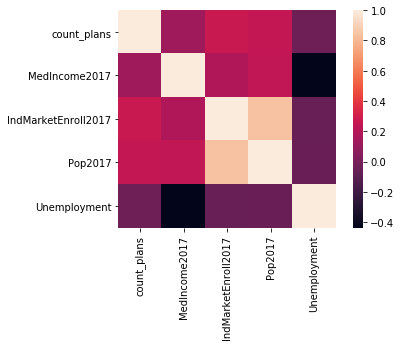

In [31]:
# Compute correlation between continous variables (all continous features and target variable)
varsel = plans_ahrf[['count_plans','MedIncome2017','IndMarketEnroll2017','Pop2017','Unemployment']][plans_ahrf['Unemployment'].notnull()]
print(len(varsel))
print(varsel.corr())
sns.heatmap(varsel.corr(),square=True)

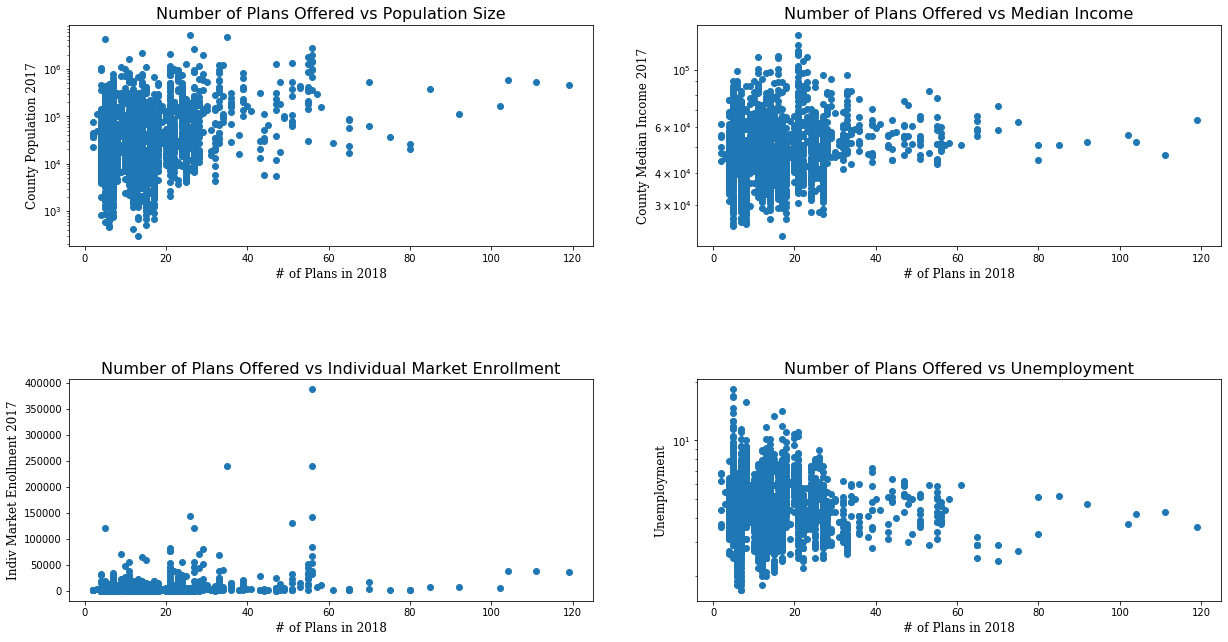

<Figure size 432x288 with 0 Axes>

In [32]:
# Plot all continous features and target variable 
plt.figure(figsize=(20,10))

plt.subplot(221)
_ = plt.scatter(x = plans_data['count_plans'], y = plans_data['Pop2017'])
_ = plt.yscale('log')
_ = plt.xlabel("# of Plans in 2018",fontdict=font)
_ = plt.ylabel("County Population 2017",fontdict=font)
_ = plt.title("Number of Plans Offered vs Population Size", fontsize=16)

plt.subplot(222)
_ = plt.scatter(x = plans_data['count_plans'], y = plans_data['MedIncome2017'])
_ = plt.yscale('log')
_ = plt.xlabel("# of Plans in 2018",fontdict=font)
_ = plt.ylabel("County Median Income 2017",fontdict=font)
_ = plt.title("Number of Plans Offered vs Median Income", fontsize=16)

plt.subplot(223)
_ = plt.scatter(x = plans_data['count_plans'], y = plans_data['IndMarketEnroll2017'])
_ = plt.xlabel("# of Plans in 2018",fontdict=font)
_ = plt.ylabel("Indiv Market Enollment 2017",fontdict=font)
#plt.yscale('log')
_ = plt.title("Number of Plans Offered vs Individual Market Enrollment", fontsize=16)

plt.subplot(224)
_ = plt.scatter(x = plans_data['count_plans'], y = plans_data['Unemployment'])
_ = plt.xlabel("# of Plans in 2018",fontdict=font)
_ = plt.ylabel("Unemployment",fontdict=font)
_ = plt.yscale('log')
_ = plt.title("Number of Plans Offered vs Unemployment", fontsize=16)

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9 , hspace=.6)
plt.show()
plt.savefig("figure 4.png")

In [33]:
#X_raw = plans_data[['state', 'Pop2017', 'MedIncome2017','IndMarketEnroll2017','Unemployment','Pparty']]
def label_ind (row):
   if row['CBSA_Ind'] == 0 :
      return 'Not a CBSA'
   if row['CBSA_Ind'] == 1 :
      return 'MetroCBSA'
   if row['CBSA_Ind'] == 2 :
      return 'MicroCBSA'

cbsa_type = plans_data.apply (lambda row: label_ind(row), axis=1)
lpop = np.log(plans_ahrf['Pop2017'])
lmedinc = np.log(plans_ahrf['MedIncome2017'])
# there are instances where enrollment is zero.
lenrol = np.log(plans_ahrf['IndMarketEnroll2017']+1)
lunemp = np.log(plans_ahrf['Unemployment'])

X_raw = pd.DataFrame(data={'cbsa_type': cbsa_type, 'lpop': lpop, 'lmedinc': lmedinc, 'lenrol': lenrol, 'lunemp': lunemp, 'state': plans_data.state, 'Pparty': plans_data.Pparty})
Y = np.log(plans_data[['count_plans']])

# Generate dumies from categorical variables and drop one level to avoid colinearity. 
X = pd.get_dummies(X_raw)
X = X.drop(['state_Wisconsin','cbsa_type_MetroCBSA','Pparty_Republican'],axis=1)
print(X.shape)
#print(X.info())
#print(X.describe())

(2718, 46)


## Linear Regression and Cross Validation

R2:  0.6553405782077275


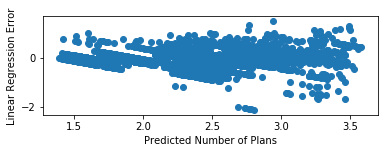

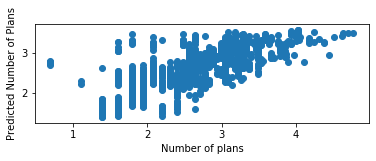

In [34]:
# TRADITIONAL LINEAR REGRESSION
# Look at the residuals - they show heteroscedasticity (applying logs before fitting not enough)
reg = LinearRegression()
reg.fit(X,Y)
Y_hat = reg.predict(X)
error = Y - Y_hat
print("R2: ",r2_score(Y, Y_hat))

plt.subplot(211)
plt.scatter(Y_hat, error)
plt.xlabel("Predicted Number of Plans")
plt.ylabel("Linear Regression Error")
plt.show()

plt.subplot(212)
plt.scatter(Y,Y_hat)
plt.ylabel("Predicted Number of Plans")
plt.xlabel("Number of plans")
plt.show()

In [35]:
# Apply Cross Validation to the Linear Regression Fit - Explore laternative models penalizing for number of variables included
# in the model: Ridge and Lasso regression 

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

def model (form, score, scoref):
    reg = form()
    cv_scr = cross_val_score(reg, X_train, Y_train, cv=3, scoring=score).sum()/3
    reg.fit(X_train,Y_train)
    params = list(reg.coef_)
    test_scr = scoref(Y_test, reg.predict(X_test))
    return cv_scr, test_scr, params

def modcomp (form, matrix1, num):
    matrix1[num,0], matrix1[num,1], coef = model(form = form, score = 'neg_mean_squared_error', scoref = mean_squared_error)
    matrix1[num,2], matrix1[num,3], _c = model(form = form, score = 'neg_mean_absolute_error', scoref = mean_absolute_error)
    matrix1[num,4], matrix1[num,5], _c = model(form = form, score = 'r2', scoref = r2_score)
    return coef

cv_scr_models =  np.empty(shape=(3,6),dtype='object')
#params = pd.DataFrame(np.empty(shape=(len(X.columns),3), dtype='object'))

prms = modcomp(LinearRegression,cv_scr_models, 0)
param1=pd.Series(prms[0],index=X.columns)
prms = modcomp(Ridge,cv_scr_models, 1)
param2 = pd.Series(prms[0],index=X.columns)
prms = modcomp(Lasso,cv_scr_models, 2)
param3 = pd.Series(prms[0],index=X.columns)

params = pd.concat([param1,param2,param3],axis=1)
params.columns=["LinearRegression","Ridge","Lasso"]
cv_scr_comp = pd.DataFrame(cv_scr_models,index=["Linear Regression","Ridge Regression", "Lasso Regression"],
                           columns=["Cross Validation MSE","Test MSE","Cross Validation MAE","Test MAE","Cross Validation R2","Test R2"])


In [36]:
print(cv_scr_comp)
print(params)

                  Cross Validation MSE  Test MSE Cross Validation MAE  \
Linear Regression            -0.134942  0.152626            -0.252677   
Ridge Regression             -0.138125  0.158675            -0.258619   
Lasso Regression              -0.38186  0.406709            -0.511215   

                   Test MAE Cross Validation R2     Test R2  
Linear Regression   0.27577            0.645058    0.623415  
Ridge Regression   0.282036            0.636567    0.608491  
Lasso Regression   0.513361         -0.00421074 -0.00350256  
                      LinearRegression     Ridge  Lasso
lpop                          0.060082  0.039291    0.0
lmedinc                       0.050449  0.047320    0.0
lenrol                       -0.004462  0.020381    0.0
lunemp                       -0.042375 -0.063538    0.0
cbsa_type_MicroCBSA          -0.083561 -0.081756    0.0
cbsa_type_Not a CBSA         -0.013917 -0.009753    0.0
state_Alabama                -1.197970 -0.924789    0.0
state_Alask

### Ensemble Methods

In [37]:
# Fit Random Forest Regression

# Train the Model
X_train, X_test, Y_train, Y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size = 0.3, random_state = 42)

rf_mod = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_mod.fit(X_train,Y_train.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [38]:
# Use the Model to Predict the Test set and Evaluate the fit

Y_test_pred = rf_mod.predict(X_test)

# Calculate the errors
errors = np.exp(Y_test_pred) - np.exp(Y_test)
errors_perc = errors/np.exp(Y_test)
# Print the mean absolute error (MAE) in number of plans unit and percentage
print('Mean Absolute Error:', round(np.exp(np.mean(abs(errors_perc))), 2), "%")

Mean Absolute Error: 2.24 %


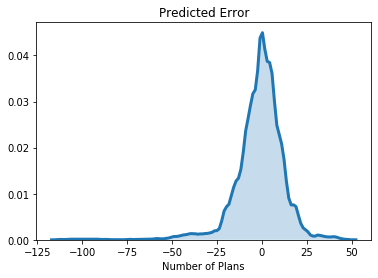

In [40]:
_ = sns.distplot(errors, hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3})
_ = plt.title("Predicted Error")
_ = plt.xlabel("Number of Plans")

In [ ]:
# Bagging Regressor

